In [2]:
# import requiered python libabries
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, normalize


In [15]:
import os
import sys
import warnings
warnings.filterwarnings('ignore')
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from dataframe_cleaner import DataFrameCleaner
from dataframe_outlier import *
from plot_data import *
from dataframe_info import DataFrameInfo


In [16]:
from user_overview import UserOverviewScript

In [7]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option("expand_frame_repr", False)
pd.set_option('display.float_format', '{:.2f}'.format)

In [9]:
# load and read cleaned telecom-dataset
df_cleaned = pd.read_csv('../data/cleaned_Telecom_data.csv')

In [10]:
#info about the dataset
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148506 entries, 0 to 148505
Data columns (total 54 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Unnamed: 0                      148506 non-null  int64  
 1   Unnamed:_0                      148506 non-null  int64  
 2   Bearer_Id                       148506 non-null  float64
 3   Start                           148506 non-null  object 
 4   Start_ms                        148506 non-null  int64  
 5   End                             148506 non-null  object 
 6   End_ms                          148506 non-null  int64  
 7   Dur._(ms)                       148506 non-null  int64  
 8   IMSI                            148506 non-null  float64
 9   MSISDN_Number                   148506 non-null  float64
 10  IMEI                            148506 non-null  float64
 11  Last_Location_Name              148506 non-null  object 
 12  Avg_RTT_DL_(ms) 

## Task 3: User Experience Analytics 
Aggregate, per customer, the following information(treat missing & outliers by replacing by the mean or the mode of the corresponding variable

In [17]:
df_user_expr = df_cleaned[[
    "MSISDN_Number",
    "Avg_RTT_DL_(ms)",
    "Avg_RTT_UL_(ms)",
    "Avg_Bearer_TP_DL_(kbps)",
    "Avg_Bearer_TP_UL_(kbps)",
    "Handset_Type"]].copy()

In [18]:
#reusing classes fromscript folder
user_overview = UserOverviewScript(df_user_expr)

In [21]:
#converting average RTT millisecond values to second
df_user_expr['Avg_RTT_DL_(ms)'] = user_overview.convert_ms_to_sec(\
    df_user_expr['Avg_RTT_DL_(ms)'])

df_user_expr['Avg_RTT_UL_(ms)'] = user_overview.convert_ms_to_sec(\
    df_user_expr['Avg_RTT_UL_(ms)'])

In [23]:
# get the TCP Retransmission volume from the original data, deleted during preprocessing
df_original = pd.read_csv('../data/Week1_challenge_data_source.csv')
df_user_expr['TCP_DL_Retrans_Vol_(Bytes)'] = df_original['TCP DL Retrans. Vol (Bytes)']
df_user_expr['TCP_UL_Retrans_Vol_(Bytes)'] = df_original['TCP UL Retrans. Vol (Bytes)']

In [24]:
df_user_expr['TCP_DL_Retrans_Vol_(Bytes)'] = user_overview.convert_bytes_to_kbytes(\
    df_user_expr['TCP_DL_Retrans_Vol_(Bytes)'])

df_user_expr['TCP_UL_Retrans_Vol_(Bytes)'] = user_overview.convert_bytes_to_kbytes(\
    df_user_expr['TCP_UL_Retrans_Vol_(Bytes)'])

df_user_expr.rename(columns = {\
        'Avg_RTT_DL_(ms)':'Avg_RTT_DL_(sec)',\
        'Avg_RTT_UL_(ms)':'Avg_RTT_UL_(sec)',\
        'TCP_DL_Retrans_Vol_(Bytes)':'TCP_DL_Retrans_Vol_(kbps)',\
        'TCP_UL_Retrans_Vol_(Bytes)':'TCP_UL_Retrans_Vol_(kbps)'
    }, inplace=True)

In [25]:
# checking null values
df_user_expr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148506 entries, 0 to 148505
Data columns (total 8 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   MSISDN_Number              148506 non-null  float64
 1   Avg_RTT_DL_(sec)           148506 non-null  float64
 2   Avg_RTT_UL_(sec)           148506 non-null  float64
 3   Avg_Bearer_TP_DL_(kbps)    148506 non-null  int64  
 4   Avg_Bearer_TP_UL_(kbps)    148506 non-null  int64  
 5   Handset_Type               148506 non-null  object 
 6   TCP_DL_Retrans_Vol_(kbps)  61271 non-null   float64
 7   TCP_UL_Retrans_Vol_(kbps)  52879 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 9.1+ MB


Treating the null values

In [27]:
#handle null values with mean and median
df_user_expr = DataFrameCleaner(df_user_expr)
columns = ['TCP_DL_Retrans_Vol_(kbps)', 'TCP_UL_Retrans_Vol_(kbps)']
df_user_expr.fill_numerical_column(columns)

In [29]:
#check if there any count values
df_user_expr = DataFrameInfo(df_user_expr.df)
df_user_expr.get_null_counts()

MSISDN_Number                0
Avg_RTT_DL_(sec)             0
Avg_RTT_UL_(sec)             0
Avg_Bearer_TP_DL_(kbps)      0
Avg_Bearer_TP_UL_(kbps)      0
Handset_Type                 0
TCP_DL_Retrans_Vol_(kbps)    0
TCP_UL_Retrans_Vol_(kbps)    0
dtype: int64


In [30]:
df_user_expr = df_user_expr.df

In [31]:
df_user_expr['Total_Avg_RTT'] = df_user_expr['Avg_RTT_DL_(sec)']+\
                                df_user_expr['Avg_RTT_UL_(sec)']
df_user_expr['Total_Avg_Bearer_TP'] = df_user_expr['Avg_Bearer_TP_DL_(kbps)']+\
                                df_user_expr['Avg_Bearer_TP_UL_(kbps)']
df_user_expr['Total_Avg_TCP'] = df_user_expr['TCP_DL_Retrans_Vol_(kbps)']+\
                                df_user_expr['TCP_UL_Retrans_Vol_(kbps)']
df_user_expr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148506 entries, 0 to 148505
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   MSISDN_Number              148506 non-null  float64
 1   Avg_RTT_DL_(sec)           148506 non-null  float64
 2   Avg_RTT_UL_(sec)           148506 non-null  float64
 3   Avg_Bearer_TP_DL_(kbps)    148506 non-null  int64  
 4   Avg_Bearer_TP_UL_(kbps)    148506 non-null  int64  
 5   Handset_Type               148506 non-null  object 
 6   TCP_DL_Retrans_Vol_(kbps)  148506 non-null  float64
 7   TCP_UL_Retrans_Vol_(kbps)  148506 non-null  float64
 8   Total_Avg_RTT              148506 non-null  float64
 9   Total_Avg_Bearer_TP        148506 non-null  int64  
 10  Total_Avg_TCP              148506 non-null  float64
dtypes: float64(7), int64(3), object(1)
memory usage: 12.5+ MB


In [35]:
user_expr_agg = df_user_expr.groupby('MSISDN_Number').agg({
   'Total_Avg_RTT': 'sum',
   'Total_Avg_Bearer_TP': 'sum',
   'Total_Avg_TCP': 'sum', 'Handset_Type': [lambda x: x.mode()[0]]})

user_expr = pd.DataFrame(columns=[
   "Total_Avg_RTT",
    "Total_Avg_Bearer_TP",
    "Total_Avg_TCP",
    "Handset_Type" 
])

user_expr["Total_Avg_RTT"] = user_expr_agg["Total_Avg_RTT"]['sum']
user_expr["Total_Avg_Bearer_TP"] = user_expr_agg["Total_Avg_Bearer_TP"]['sum']
user_expr["Total_Avg_TCP"] = user_expr_agg["Total_Avg_TCP"]['sum']
user_expr["Handset_Type"] = user_expr_agg["Handset_Type"]['<lambda>']
user_expr.head()


,Total_Avg_RTT,Total_Avg_Bearer_TP,Total_Avg_TCP,Handset_Type
MSISDN_Number,,,,
33601001722.00,0.00,76,46428.31,Huawei P20 Lite Huawei Nova 3E
33601001754.00,0.00,99,580.35,Apple iPhone 7 (A1778)
33601002511.00,0.01,97,580.35,undefined
33601007832.00,0.02,248,198.99,Apple iPhone 5S (A1457)
33601008617.00,0.01,56844,970.59,Apple iPhone Se (A1723)


<AxesSubplot:>

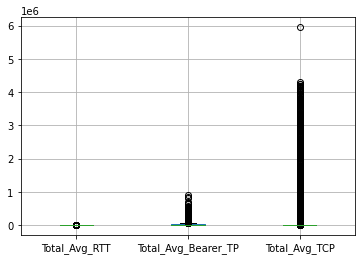

In [36]:
# To treat outlier
user_expr.boxplot()

In [ ]:
#removing outlier
